In [32]:
!pip install yfinance pandas numpy matplotlib seaborn plotly scipy scikit-learn openpyxl

In [33]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [34]:
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

In [35]:
ticker = "AMZN"
stock = yf.Ticker(ticker)
data = stock.history(period="6y")
data.index = pd.to_datetime(data.index)
print(f"Data fetched successfully: {len(data)} trading days from {data.index[0].date()} to {data.index[-1].date()}")

Data fetched successfully: 1508 trading days from 2019-07-03 to 2025-07-02


In [36]:
data.shape

(1508, 7)

In [37]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')

In [38]:
data.isnull().sum()

,0
Open,0
High,0
Low,0
Close,0
Volume,0
Dividends,0
Stock Splits,0


In [39]:
data['SMA_20'] = data['Close'].rolling(window=20).mean()  # 20-day simple moving average
data['SMA_50'] = data['Close'].rolling(window=50).mean()  # 50-day simple moving average
data['SMA_200'] = data['Close'].rolling(window=200).mean()  # 200-day simple moving average
data['EMA_12'] = data['Close'].ewm(span=12).mean()  # 12-day exponential moving average
data['EMA_26'] = data['Close'].ewm(span=26).mean()  # 26-day exponential moving average


In [40]:
data['MACD'] = data['EMA_12'] - data['EMA_26']  # MACD line
data['MACD_Signal'] = data['MACD'].ewm(span=9).mean()  # MACD signal line
data['MACD_Histogram'] = data['MACD'] - data['MACD_Signal']

In [41]:
delta = data['Close'].diff()  # Daily price changes
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()  # Average gains
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()  # Average losses
rs = gain / loss  # Relative strength
data['RSI'] = 100 - (100 / (1 + rs))

In [42]:
data['BB_Middle'] = data['Close'].rolling(window=20).mean()  # Middle band (20-day SMA)
bb_std = data['Close'].rolling(window=20).std()  # 20-day standard deviation
data['BB_Upper'] = data['BB_Middle'] + (bb_std * 2)  # Upper band
data['BB_Lower'] = data['BB_Middle'] - (bb_std * 2)  # Lower band
data['BB_Width'] = data['BB_Upper'] - data['BB_Lower']

In [43]:
data['Volume_SMA'] = data['Volume'].rolling(window=20).mean()  # 20-day volume average
data['Volume_Ratio'] = data['Volume'] / data['Volume_SMA']

In [44]:
data['Daily_Return'] = data['Close'].pct_change()  # Daily percentage returns
data['Volatility_20'] = data['Daily_Return'].rolling(window=20).std() * np.sqrt(252)

In [45]:
returns = data['Daily_Return'].dropna()

In [46]:
annual_return = returns.mean() * 252  # Annualized return
annual_volatility = returns.std() * np.sqrt(252)  # Annualized volatility
sharpe_ratio = annual_return / annual_volatility

In [47]:
negative_returns = returns[returns < 0]  # Filter negative returns
downside_deviation = negative_returns.std() * np.sqrt(252)  # Downside deviation
sortino_ratio = annual_return / downside_deviation

In [48]:
cumulative_returns = (1 + returns).cumprod()  # Cumulative returns
running_max = cumulative_returns.expanding().max()  # Running maximum
drawdown = (cumulative_returns - running_max) / running_max  # Drawdown series
max_drawdown = drawdown.min()

In [49]:
var_95 = np.percentile(returns, 5)  # 95% VaR (5th percentile)
var_99 = np.percentile(returns, 1)  # 99% VaR (1st percentile)
cvar_95 = returns[returns <= var_95].mean()

In [50]:
skewness = returns.skew()
kurtosis = returns.kurtosis()

In [51]:
risk_metrics = {
    'Annual_Return': annual_return,
    'Annual_Volatility': annual_volatility,
    'Sharpe_Ratio': sharpe_ratio,
    'Sortino_Ratio': sortino_ratio,
    'Max_Drawdown': max_drawdown,
    'VaR_95': var_95,
    'VaR_99': var_99,
    'CVaR_95': cvar_95,
    'Skewness': skewness,
    'Kurtosis': kurtosis
}


In [52]:
for metric, value in risk_metrics.items():
    print(f"{metric}: {value:.4f}")

Annual_Return: 0.1982
Annual_Volatility: 0.3502
Sharpe_Ratio: 0.5660
Sortino_Ratio: 0.8306
Max_Drawdown: -0.5615
VaR_95: -0.0324
VaR_99: -0.0557
CVaR_95: -0.0489
Skewness: 0.1483
Kurtosis: 4.4986


In [53]:
phases = {
    'Pre-COVID Bull Market': ('2019-01-01', '2020-02-19'),
    'COVID Market Crash': ('2020-02-20', '2020-03-23'),
    'COVID Recovery Rally': ('2020-03-24', '2021-12-31'),
    'Interest Rate Cycle': ('2022-01-01', '2024-12-31')
}

In [54]:
phase_analysis = {}
for phase_name, (start_date, end_date) in phases.items():
    try:
        phase_data = data[start_date:end_date]['Daily_Return'].dropna()
        if len(phase_data) > 0:
            total_return = (1 + phase_data).prod() - 1
            volatility = phase_data.std() * np.sqrt(252)
            sharpe = (phase_data.mean() * 252) / volatility if volatility > 0 else 0
            max_gain = phase_data.max()
            max_loss = phase_data.min()

            phase_analysis[phase_name] = {
                'Total_Return': total_return,
                'Volatility': volatility,
                'Sharpe_Ratio': sharpe,
                'Max_Daily_Gain': max_gain,
                'Max_Daily_Loss': max_loss,
                'Trading_Days': len(phase_data)
            }
    except Exception as e:
        print(f"Could not analyze phase {phase_name}: {e}")

print("Market Phase Analysis:")
for phase, metrics in phase_analysis.items():
    print(f"\n{phase}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

Market Phase Analysis:

Pre-COVID Bull Market:
  Total_Return: 0.1192
  Volatility: 0.2062
  Sharpe_Ratio: 0.9730
  Max_Daily_Gain: 0.0738
  Max_Daily_Loss: -0.0336
  Trading_Days: 158.0000

COVID Market Crash:
  Total_Return: -0.1232
  Volatility: 0.6404
  Sharpe_Ratio: -1.9367
  Max_Daily_Gain: 0.0703
  Max_Daily_Loss: -0.0792
  Trading_Days: 23.0000

COVID Recovery Rally:
  Total_Return: 0.7523
  Volatility: 0.3008
  Sharpe_Ratio: 1.1972
  Max_Daily_Gain: 0.0793
  Max_Daily_Loss: -0.0760
  Trading_Days: 449.0000

Interest Rate Cycle:
  Total_Return: 0.3159
  Volatility: 0.3833
  Sharpe_Ratio: 0.4312
  Max_Daily_Gain: 0.1354
  Max_Daily_Loss: -0.1405
  Trading_Days: 753.0000


In [55]:
data['Signal_MA'] = 0
data['Signal_MACD'] = 0
data['Signal_RSI'] = 0
data['Signal_BB'] = 0

In [56]:
ma_condition_bull = (data['SMA_20'] > data['SMA_50']) & (data['SMA_50'] > data['SMA_200'])
ma_condition_bear = (data['SMA_20'] < data['SMA_50']) & (data['SMA_50'] < data['SMA_200'])
data['Signal_MA'] = np.where(ma_condition_bull, 1, np.where(ma_condition_bear, -1, 0))

In [57]:
macd_bull_cross = (data['MACD'] > data['MACD_Signal']) & (data['MACD'].shift(1) <= data['MACD_Signal'].shift(1))
macd_bear_cross = (data['MACD'] < data['MACD_Signal']) & (data['MACD'].shift(1) >= data['MACD_Signal'].shift(1))
data['Signal_MACD'] = np.where(macd_bull_cross, 1, np.where(macd_bear_cross, -1, 0))

In [58]:
rsi_oversold = (data['RSI'] < 30) & (data['RSI'].shift(1) >= 30)
rsi_overbought = (data['RSI'] > 70) & (data['RSI'].shift(1) <= 70)
data['Signal_RSI'] = np.where(rsi_oversold, 1, np.where(rsi_overbought, -1, 0))

In [59]:
bb_oversold = data['Close'] < data['BB_Lower']
bb_overbought = data['Close'] > data['BB_Upper']
data['Signal_BB'] = np.where(bb_oversold, 1, np.where(bb_overbought, -1, 0))

In [60]:
signals = ['Signal_MA', 'Signal_MACD', 'Signal_RSI', 'Signal_BB']
data['Composite_Signal'] = data[signals].sum(axis=1)

data['Final_Signal'] = np.where(
    data['Composite_Signal'] >= 2, 1,
    np.where(data['Composite_Signal'] <= -2, -1, 0)
)

buy_signals = (data['Final_Signal'] == 1).sum()
sell_signals = (data['Final_Signal'] == -1).sum()
hold_signals = (data['Final_Signal'] == 0).sum()

print(f"Trading Signals Generated:")
print(f"Buy Signals: {buy_signals}")
print(f"Sell Signals: {sell_signals}")
print(f"Hold Signals: {hold_signals}")

Trading Signals Generated:
Buy Signals: 43
Sell Signals: 30
Hold Signals: 1435


In [61]:
initial_capital = 100000
position = 0
cash = initial_capital
portfolio_value = []
transaction_cost = 0.001

In [62]:
for i in range(len(data)):
    current_price = data['Close'].iloc[i]
    signal = data['Final_Signal'].iloc[i]

    if signal == 1 and position <= 0:
        shares_to_buy = cash / current_price
        position += shares_to_buy * (1 - transaction_cost)
        cash = 0

    elif signal == -1 and position > 0:
        cash = position * current_price * (1 - transaction_cost)
        position = 0

    total_value = cash + (position * current_price)
    portfolio_value.append(total_value)


In [63]:
data['Portfolio_Value'] = portfolio_value
data['Strategy_Return'] = data['Portfolio_Value'].pct_change()

In [64]:
strategy_returns = data['Strategy_Return'].dropna()
total_return = (portfolio_value[-1] / initial_capital) - 1
strategy_annual_return = strategy_returns.mean() * 252
strategy_volatility = strategy_returns.std() * np.sqrt(252)
strategy_sharpe = strategy_annual_return / strategy_volatility

In [65]:
strategy_cumulative = data['Portfolio_Value'] / data['Portfolio_Value'].expanding().max()
strategy_drawdown = (strategy_cumulative - 1).min()

In [66]:
buy_hold_return = (data['Close'].iloc[-1] / data['Close'].iloc[0]) - 1
buy_hold_value = initial_capital * (1 + buy_hold_return)

In [67]:
strategy_performance = {
    'Total_Return': total_return,
    'Annual_Return': strategy_annual_return,
    'Annual_Volatility': strategy_volatility,
    'Sharpe_Ratio': strategy_sharpe,
    'Max_Drawdown': strategy_drawdown,
    'Final_Portfolio_Value': portfolio_value[-1],
    'Buy_Hold_Return': buy_hold_return,
    'Buy_Hold_Value': buy_hold_value,
    'Excess_Return': total_return - buy_hold_return
}

In [68]:
print("Strategy Performance Results:")
for metric, value in strategy_performance.items():
    print(f"{metric}: {value:.4f}")

Strategy Performance Results:
Total_Return: 0.5705
Annual_Return: 0.1016
Annual_Volatility: 0.2292
Sharpe_Ratio: 0.4433
Max_Drawdown: -0.3091
Final_Portfolio_Value: 157052.6861
Buy_Hold_Return: 1.2684
Buy_Hold_Value: 226838.5818
Excess_Return: -0.6979


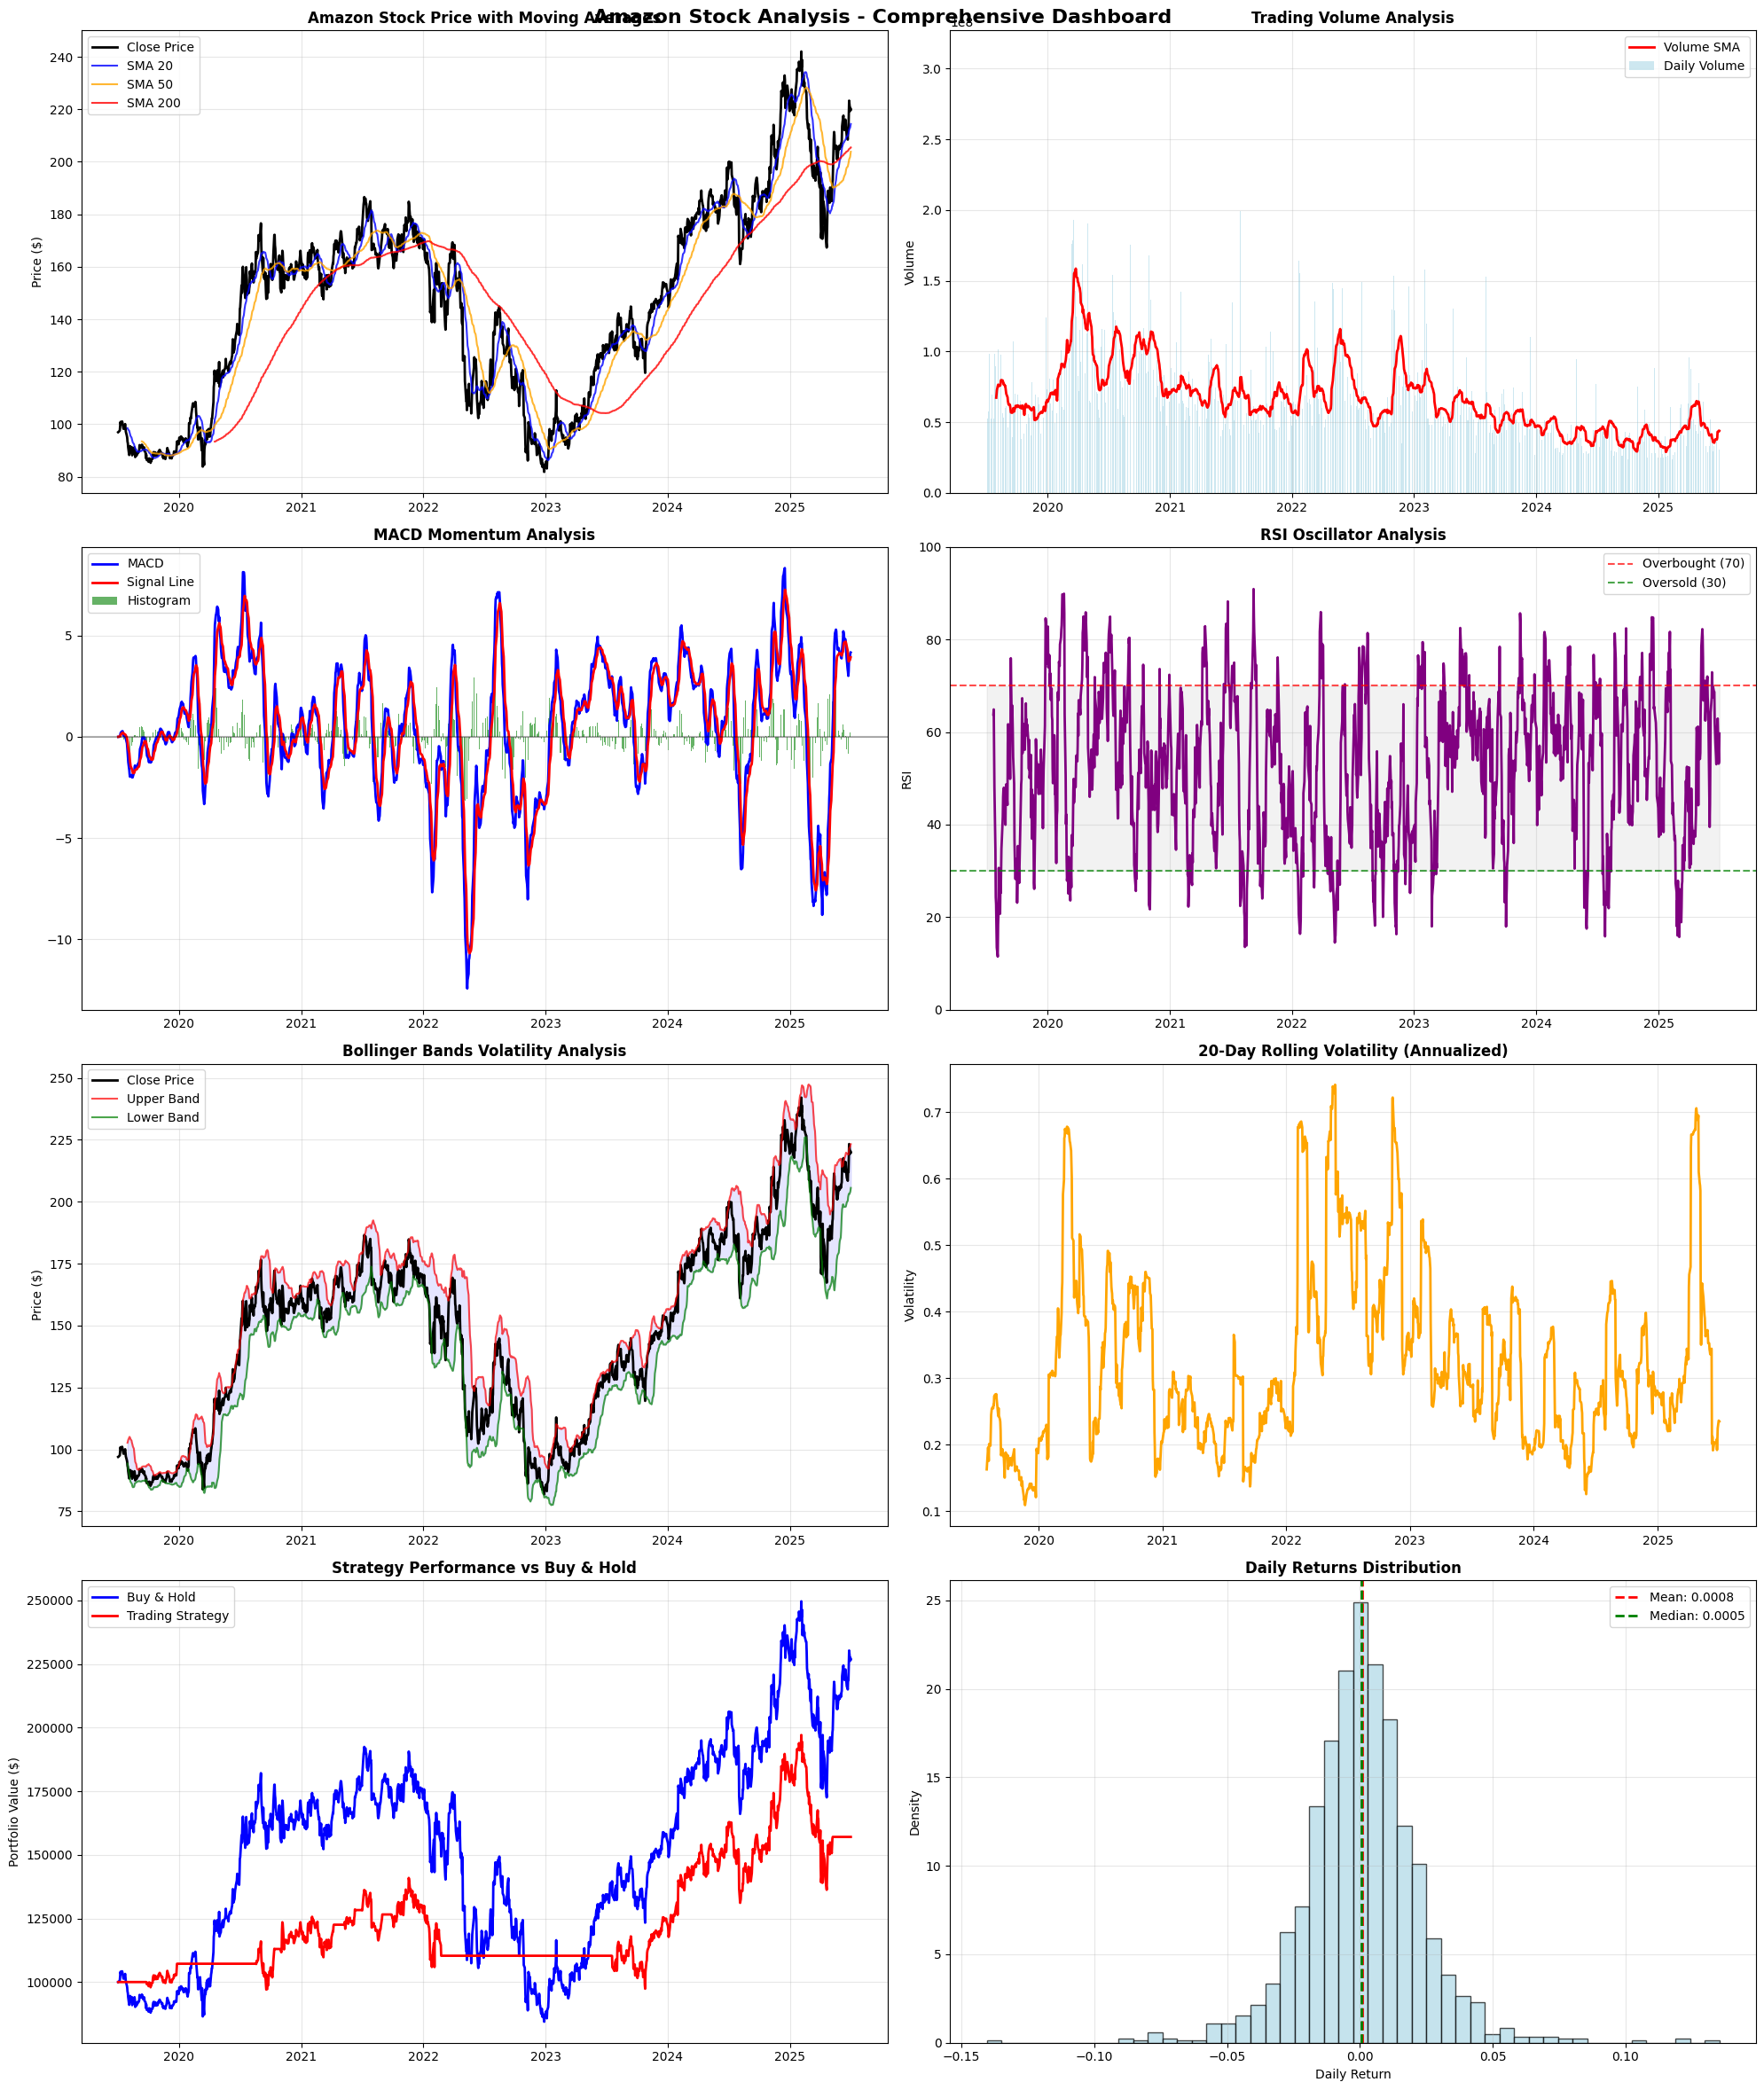

In [69]:
fig, axes = plt.subplots(4, 2, figsize=(20, 24))
fig.suptitle('Amazon Stock Analysis - Comprehensive Dashboard', fontsize=16, fontweight='bold')

# Price Chart with Moving Averages
axes[0, 0].plot(data.index, data['Close'], label='Close Price', linewidth=2, color='black')
axes[0, 0].plot(data.index, data['SMA_20'], label='SMA 20', alpha=0.8, color='blue')
axes[0, 0].plot(data.index, data['SMA_50'], label='SMA 50', alpha=0.8, color='orange')
axes[0, 0].plot(data.index, data['SMA_200'], label='SMA 200', alpha=0.8, color='red')
axes[0, 0].set_title('Amazon Stock Price with Moving Averages', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_ylabel('Price ($)')

# Trading Volume Analysis
axes[0, 1].bar(data.index, data['Volume'], alpha=0.6, color='lightblue', label='Daily Volume')
axes[0, 1].plot(data.index, data['Volume_SMA'], color='red', label='Volume SMA', linewidth=2)
axes[0, 1].set_title('Trading Volume Analysis', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylabel('Volume')

# MACD Momentum Analysis
axes[1, 0].plot(data.index, data['MACD'], label='MACD', linewidth=2, color='blue')
axes[1, 0].plot(data.index, data['MACD_Signal'], label='Signal Line', linewidth=2, color='red')
axes[1, 0].bar(data.index, data['MACD_Histogram'], alpha=0.6, color='green', label='Histogram')
axes[1, 0].set_title('MACD Momentum Analysis', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)

# RSI Oscillator
axes[1, 1].plot(data.index, data['RSI'], linewidth=2, color='purple')
axes[1, 1].axhline(y=70, color='r', linestyle='--', alpha=0.7, label='Overbought (70)')
axes[1, 1].axhline(y=30, color='g', linestyle='--', alpha=0.7, label='Oversold (30)')
axes[1, 1].fill_between(data.index, 30, 70, alpha=0.1, color='gray')
axes[1, 1].set_title('RSI Oscillator Analysis', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylabel('RSI')
axes[1, 1].set_ylim(0, 100)

# Bollinger Bands
axes[2, 0].plot(data.index, data['Close'], label='Close Price', linewidth=2, color='black')
axes[2, 0].plot(data.index, data['BB_Upper'], label='Upper Band', alpha=0.7, color='red')
axes[2, 0].plot(data.index, data['BB_Lower'], label='Lower Band', alpha=0.7, color='green')
axes[2, 0].fill_between(data.index, data['BB_Lower'], data['BB_Upper'], alpha=0.1, color='blue')
axes[2, 0].set_title('Bollinger Bands Volatility Analysis', fontsize=12, fontweight='bold')
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3)
axes[2, 0].set_ylabel('Price ($)')

# Rolling Volatility
axes[2, 1].plot(data.index, data['Volatility_20'], linewidth=2, color='orange')
axes[2, 1].set_title('20-Day Rolling Volatility (Annualized)', fontsize=12, fontweight='bold')
axes[2, 1].set_ylabel('Volatility')
axes[2, 1].grid(True, alpha=0.3)

# Strategy vs Buy & Hold Performance
buy_hold_portfolio = (data['Close'] / data['Close'].iloc[0]) * initial_capital
axes[3, 0].plot(data.index, buy_hold_portfolio, label='Buy & Hold', linewidth=2, color='blue')
axes[3, 0].plot(data.index, data['Portfolio_Value'], label='Trading Strategy', linewidth=2, color='red')
axes[3, 0].set_title('Strategy Performance vs Buy & Hold', fontsize=12, fontweight='bold')
axes[3, 0].legend()
axes[3, 0].grid(True, alpha=0.3)
axes[3, 0].set_ylabel('Portfolio Value ($)')

# Daily Returns Distribution
returns_clean = data['Daily_Return'].dropna()
axes[3, 1].hist(returns_clean, bins=50, alpha=0.7, density=True, color='lightblue', edgecolor='black')
axes[3, 1].axvline(returns_clean.mean(), color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {returns_clean.mean():.4f}')
axes[3, 1].axvline(returns_clean.median(), color='green', linestyle='--', linewidth=2,
                   label=f'Median: {returns_clean.median():.4f}')
axes[3, 1].set_title('Daily Returns Distribution', fontsize=12, fontweight='bold')
axes[3, 1].legend()
axes[3, 1].grid(True, alpha=0.3)
axes[3, 1].set_ylabel('Density')
axes[3, 1].set_xlabel('Daily Return')


plt.tight_layout()
plt.savefig('amazon_comprehensive_analysis.png', dpi=300, bbox_inches='tight')
plt.show()